## Neural Network Classification

The activity shows an example of designing and training a neural network model using TensorFlow.

Reference: https://adventuresinmachinelearning.com/neural-networks-tutorial/, https://www.tensorflow.org/tutorials/quickstart/beginner, https://www.tensorflow.org/tutorials/quickstart/advanced

### Basic Network Training

In [1]:
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

(1797, 64)


<Figure size 640x480 with 0 Axes>

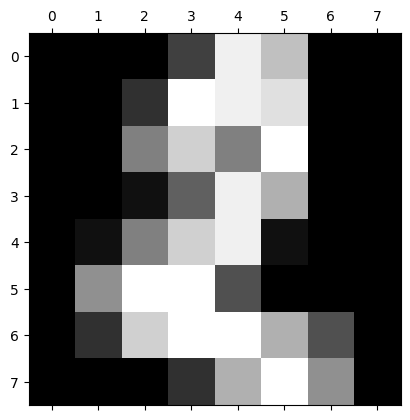

array([ 0.,  0.,  0.,  4., 15., 12.,  0.,  0.,  0.,  0.,  3., 16., 15.,
       14.,  0.,  0.,  0.,  0.,  8., 13.,  8., 16.,  0.,  0.,  0.,  0.,
        1.,  6., 15., 11.,  0.,  0.,  0.,  1.,  8., 13., 15.,  1.,  0.,
        0.,  0.,  9., 16., 16.,  5.,  0.,  0.,  0.,  0.,  3., 13., 16.,
       16., 11.,  5.,  0.,  0.,  0.,  0.,  3., 11., 16.,  9.,  0.])

In [2]:
# Load dataset, show data
digits = load_digits()
print(digits.data.shape)
plt.gray() 
plt.matshow(digits.images[2]) 
plt.show()
digits.data[2,:]

In [3]:
# Scale data
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
X[0,:]

array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

In [4]:
# Split dataset into train/test
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [5]:
# Convert output to binary (1-hot encoding) vector
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)
y_train[0], y_v_train[0]

(np.int64(8), array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [6]:
# Set up the neural network
nn_structure = [64, 30, 10]
def f(x):
    return 1 / (1 + np.exp(-x))
def f_deriv(x):
    return f(x) * (1 - f(x))


The gradient descent algorithm works as follows:

Randomly initialise the weights for each layer $W^{(l)}$.  
While iterations < iteration limit:  
1. Set $\Delta W$ and $\Delta b$ to zero.  
2. For samples 1 to m:  
   a. Perform a feed foward pass through all the $n_l$ layers. Store the activation function outputs $h^{(l)}$.  
   b. Calculate the $\delta^{(n_l)}$ value for the output layer.  
   c. Use backpropagation to calculate the $\delta^{(l)}$ values for layers 2 to $n_l-1$.  
   d. Update the $\Delta W^{(l)}$ and $\Delta b^{(l)}$  for each layer.  
3. Perform a gradient descent step using:  
$W^{(l)} = W^{(l)}-\alpha[\frac{1}{m}\Delta W^{(l)}]$,  
$b^{(l)} = b^{(l)}-\alpha[\frac{1}{m}\Delta b^{(l)}]$.

In [7]:
# Initialize parameters to random values
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

def feed_forward(x, W, b):
    h = {1: x}
    z = {}
    for l in range(1, len(W) + 1):
        # if it is the first layer, then the input into the weights is x, otherwise, 
        # it is the output from the last layer
        if l == 1:
            node_in = x
        else:
            node_in = h[l]
        z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)  
        h[l+1] = f(z[l+1]) # h^(l) = f(z^(l)) 
    return h, z

def calculate_out_layer_delta(y, h_out, z_out):
    # delta^(nl) = -(y_i - h_i^(nl)) * f'(z_i^(nl))
    return -(y-h_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    m = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(len(y)):
            delta = {}
            # perform the feed forward pass and return the stored h and z values, to be used in the
            # gradient descent step
            h, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-h[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) 
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


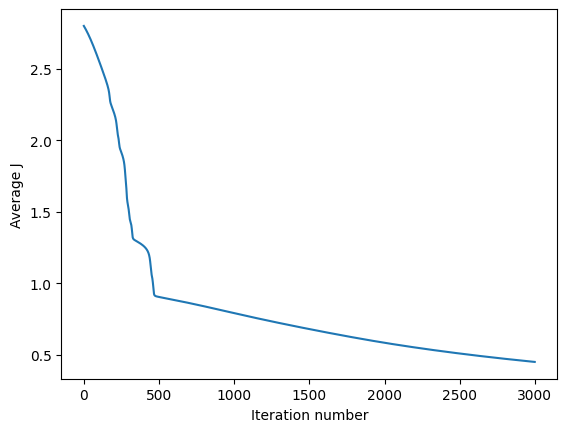

CPU times: user 1min 32s, sys: 12.1 ms, total: 1min 32s
Wall time: 1min 32s


In [8]:
%%time
# Train model and plot cost function
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train)
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [9]:
# Assess model performance
def predict_y(W, b, X, n_layers):
    m = X.shape[0]
    y = np.zeros((m,))
    for i in range(m):
        h, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(h[n_layers])
    return y

y_pred = predict_y(W, b, X_test, 3)
accuracy_score(y_test, y_pred)*100

90.26425591098747

### TensorFlow beginner version

In [11]:
# if necessary, install tensorflow
# !python -m pip install tensorflow

import tensorflow as tf
mnist = tf.keras.datasets.mnist

# load and split dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Stack the layers
tf.keras.backend.set_floatx('float64')
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# For each example the model returns a vector of "logits" or "log-odds" scores, one for each class.
predictions = model(x_train[:1]).numpy()
predictions

2025-05-21 21:47:02.006931: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 21:47:02.007543: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 21:47:02.010610: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 21:47:02.017025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747889222.030118 1203122 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747889222.03

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/home/david/anaconda3/envs/342wi25/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-05-21 21:47:04.447642: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


array([[ 0.42605343, -0.64465978, -0.83632464,  0.07362774,  0.01733539,
         0.0057504 , -0.43591   ,  0.22595035,  0.80904107,  0.19142091]])

In [12]:
# The tf.nn.softmax function converts these logits to "probabilities" for each class
tf.nn.softmax(predictions).numpy()

array([[0.13988804, 0.04794858, 0.03958556, 0.09833861, 0.09295582,
        0.09188514, 0.0590792 , 0.11451883, 0.20516818, 0.11063205]])

In [13]:
# The losses.SparseCategoricalCrossentropy loss takes a vector of logits and a True index and returns a scalar loss for each example.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(y_train[:1], predictions).numpy()

np.float64(2.3872159354885283)

In [14]:
%%time
# compile and fit/learn the model
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
  74/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5093 - loss: 1.6067   

2025-05-21 21:47:25.631345: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:47:25.632447: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:47:25.632476: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:47:25.650502: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:47:25.650614: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:47:25.650639: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8581 - loss: 0.4858
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9546 - loss: 0.1553
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9686 - loss: 0.1053
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9729 - loss: 0.0891
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9767 - loss: 0.0737
CPU times: user 53.7 s, sys: 7.41 s, total: 1min 1s
Wall time: 14.3 s


In [15]:
# evaluate the model
model.evaluate(x_test,  y_test, verbose=2)

2025-05-21 21:47:41.707101: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:47:41.707177: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:47:41.707211: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:47:41.717094: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:47:41.717165: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:47:41.717191: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE


313/313 - 0s - 1ms/step - accuracy: 0.9742 - loss: 0.0776


[0.07758945741069108, 0.9742]

In [16]:
# For each example the model returns a vector of "logits" or "log-odds" scores, one for each class.
predictions = model(x_train[:1]).numpy()

### TensorFlow Advanced

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

# Load and prepare the MNIST dataset.
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Use tf.data to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Build the tf.keras model using the Keras model subclassing API
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model
model = MyModel()

# Choose an optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Select metrics to measure the loss and the accuracy of the model.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Use tf.GradientTape to train the model
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
# test the model
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [19]:
%%time
# do the actual training
EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_state()
    train_accuracy.reset_state()
    test_loss.reset_state()
    test_accuracy.reset_state()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))

2025-05-21 21:51:10.070871: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:51:10.071078: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:51:10.071110: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:51:10.071286: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:51:10.071331: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:51:10.089379: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:51:10.089539: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:51:10.089565: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:51:10.089711: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:51:10.089736: W tensorflow/core/util/util.cc:163] Not handling type DT_DOUBLE
2025-05-21 21:51:48.484153: I tensorflow/core/framework/local_rendezvous.cc:407]

Epoch 1, Loss: 0.13633119985822476, Accuracy: 95.93333333333334, Test Loss: 0.06351376654585165, Test Accuracy: 97.94


2025-05-21 21:52:33.705856: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2, Loss: 0.04301686567680312, Accuracy: 98.69166666666666, Test Loss: 0.056993261542554595, Test Accuracy: 98.11
Epoch 3, Loss: 0.02198059282152498, Accuracy: 99.285, Test Loss: 0.055321268759557105, Test Accuracy: 98.37


2025-05-21 21:54:00.630433: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4, Loss: 0.015034607285751216, Accuracy: 99.50833333333333, Test Loss: 0.05853091319092901, Test Accuracy: 98.36
Epoch 5, Loss: 0.009202098545492707, Accuracy: 99.69666666666667, Test Loss: 0.060265470648025954, Test Accuracy: 98.34
CPU times: user 42min 21s, sys: 57.7 s, total: 43min 19s
Wall time: 3min 25s


## PyTorch Verison

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

model = Net().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training and evaluation loop
import time
start = time.time()

for epoch in range(1, 6):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = 100.0 * correct / total

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_loss /= test_total
    test_accuracy = 100.0 * test_correct / test_total

    print(f"Epoch {epoch}, Loss: {train_loss}, Accuracy: {train_accuracy}, "
          f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

end = time.time()
print(f"Training time: {end - start:.2f} seconds")
# Save the model
torch.save(model.state_dict(), 'mnist_model.pth')

Epoch 1, Loss: 0.3728999514738719, Accuracy: 89.59333333333333, Test Loss: 0.17383548468351365, Test Accuracy: 94.76
Epoch 2, Loss: 0.17461996620893477, Accuracy: 95.04166666666667, Test Loss: 0.12125341929495334, Test Accuracy: 96.61
Epoch 3, Loss: 0.12820954078038532, Accuracy: 96.22833333333334, Test Loss: 0.09911573641002178, Test Accuracy: 97.13
Epoch 4, Loss: 0.10220954126020272, Accuracy: 96.89333333333333, Test Loss: 0.08685830254107714, Test Accuracy: 97.34
Epoch 5, Loss: 0.0874946305056413, Accuracy: 97.35833333333333, Test Loss: 0.0789394410327077, Test Accuracy: 97.67
Training time: 23.18 seconds


In [23]:
# At a later time, you can load the model and evaluate it

# Load the model
model = Net()
model.load_state_dict(torch.load('mnist_model.pth'))
model.eval()
# Test the model
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
test_loss /= test_total
test_accuracy = 100.0 * test_correct / test_total
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

/tmp/ipykernel_1203122/2838543760.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mnist_model.pth'))


Test Loss: 0.0789394410327077, Test Accuracy: 97.67
